Has the popular online game Wordle gottten more difficult since it was purchased by the New York Times on January 31st 2022?

## Data Import and Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

I found the data sources for all the Wordle words on the site linked below. Reader beware, they know the Wordle words until 2027. I only included them until todays date as of writing, March 26, 2022. I did some pre-processing in excel where I extracted the date and the word.

Source: https://medium.com/@owenyin/here-lies-wordle-2021-2027-full-answer-list-52017ee99e86

In [2]:
wordle = pd.read_csv('WordleWords.csv')

The next data source needs to be something that can rank words by difficulty. This is obviously more subjective. However, I found a Kaggle dataset with english words based on frequency, which I feel is a fair way to measure difficulty. It includes 1/3 of a million words so lets home it includes all the Wordle words.

Source: https://www.kaggle.com/datasets/rtatman/english-word-frequency

In [3]:
word_freq = pd.read_csv('unigram_freq.csv')

In [4]:
wordle.head()

,Date,Word,Before_nyt
0,Jun 19 2021,CIGAR,True
1,Jun 20 2021,REBUT,True
2,Jun 21 2021,SISSY,True
3,Jun 22 2021,HUMPH,True
4,Jun 23 2021,AWAKE,True


In [5]:
wordle.shape

(278, 3)

In [6]:
word_freq.head()

,word,count
0,the,23135851162
1,of,13151942776
2,and,12997637966
3,to,12136980858
4,a,9081174698


At this point I know I need to complete three things. 
1. turn the date column into datetime
2. turn the count column into a rank with the more frequent words being lower ("the" should be 1)
3. Merge the two dataframes based on the word column. This should be a inner join so we only have the wordle words.

In [7]:
wordle['Date'] = pd.to_datetime(wordle['Date'] )

In [8]:
wordle.dtypes

Date          datetime64[ns]
Word                  object
Before_nyt              bool
dtype: object

In [9]:
word_freq['freq_rank'] = word_freq['count'].rank(ascending = 0, method  = 'min')

In [10]:
word_freq.head()

,word,count,freq_rank
0,the,23135851162,1.0
1,of,13151942776,2.0
2,and,12997637966,3.0
3,to,12136980858,4.0
4,a,9081174698,5.0


From a previous look at the word_freq df I know that some words have the same count, therefore will have the same rank. I have chosen method = 'min', which means if there is a tie the words will share the lower rank, then the next rank will be skipped. 


In [11]:
print(word_freq.tail(10))
print(wordle.shape)

           word  count  freq_rank
333323  googllr  12711   333182.0
333324  googlal  12711   333182.0
333325  googgoo  12711   333182.0
333326  googgol  12711   333182.0
333327   goofel  12711   333182.0
333328    gooek  12711   333182.0
333329   gooddg  12711   333182.0
333330  gooblle  12711   333182.0
333331   gollgo  12711   333182.0
333332    golgw  12711   333182.0
(278, 3)


Now we need to complete an inner join on the two tables on the word column. However, the words in the wordle table are uppercase, the words in the word_freq table are lowercase. 

In [12]:
wordle['Word'] = wordle['Word'].str.lower()
wordle.head()

,Date,Word,Before_nyt
0,2021-06-19,cigar,True
1,2021-06-20,rebut,True
2,2021-06-21,sissy,True
3,2021-06-22,humph,True
4,2021-06-23,awake,True


In [13]:
wordle_words = pd.merge(wordle, word_freq, left_on='Word',right_on='word')

In [14]:
wordle_words.shape

(277, 6)

Our origional wordle table had 278 rows and this output only has 277 rows. We lost one word in the process. Its not a huge deal for our analysis because we are looking at overall trends but lets try to figure out what word it was for fum.

In [15]:
for x in wordle['Word']:
    if x in wordle_words['Word']:
        print('They have', x)
else:
    print(x, "is the missing word!")

purge is the missing word!


Interesting. Purge is not a very complicated word. I wonder how it got missed. Lets look at the origional datasets again.

In [16]:
print(wordle_words['Word'].str.find('purge').value_counts())

-1    276
 0      1
Name: Word, dtype: int64


In [17]:
print(word_freq['word'].str.find('purge').value_counts())

-1.0    333323
 0.0         4
 1.0         3
 5.0         1
Name: word, dtype: int64


Interesting so purge is included in multiple words. Oh well! Lets keep it moving...

In [18]:
wordle_words.head()

,Date,Word,Before_nyt,word,count,freq_rank
0,2021-06-19,cigar,True,cigar,3993843,11600.0
1,2021-06-20,rebut,True,rebut,235254,61142.0
2,2021-06-21,sissy,True,sissy,1410911,21513.0
3,2021-06-22,humph,True,humph,60767,132781.0
4,2021-06-23,awake,True,awake,3230337,13247.0


## Data Visualization

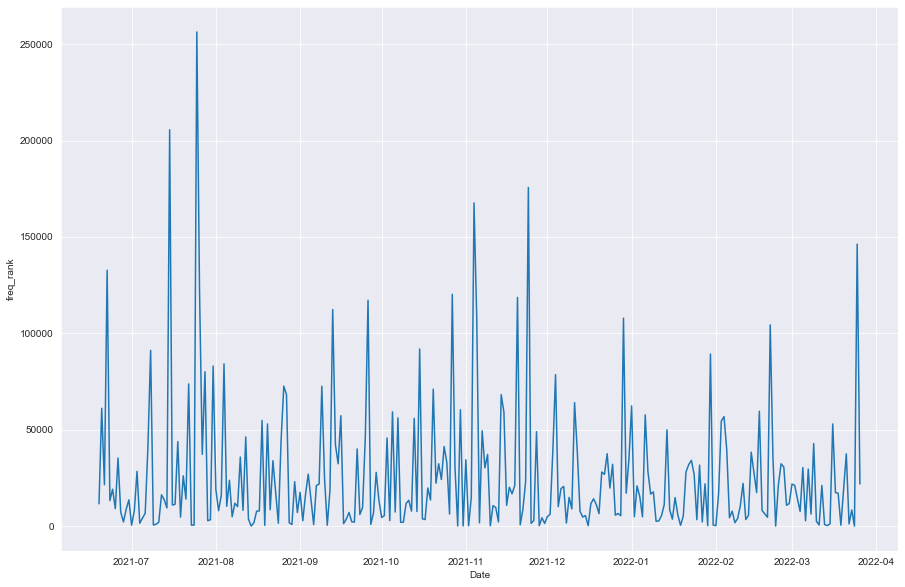

In [19]:
figure = plt.figure(figsize=(15,10))
sns.lineplot(x='Date',y='freq_rank', data=wordle_words);

In [20]:
wordle_words.groupby('Before_nyt').agg({'freq_rank':['min','max','mean','median']})

freq_rank                                 
                 min       max          mean   median
Before_nyt                                           
False           46.0  146260.0  21359.692308  13031.0
True            83.0  256340.0  27480.155556  13740.0

It looks like the wordle word difficulty rank was was actually slightly more difficult before it was purchased. 

## Hypothesis Testing

Let's see if we can prove if wordle got easier or harder with any statistical significance. alpha = 0.05

We are comparing the mean of the entire population, which is every wordle word so far, with the sample which in this case is the words since the NYT purchase date. Before we begin our hypothesis testing let's talk a look at the distribution. 

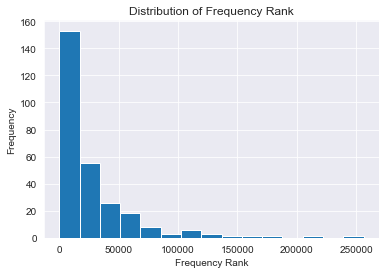

In [21]:
plt.hist(wordle_words['freq_rank'], bins= 15)
plt.title('Distribution of Frequency Rank')
plt.xlabel('Frequency Rank')
plt.ylabel('Frequency')
plt.show()

In [22]:
wordle_words['freq_rank'].agg(['skew', 'kurtosis']).transpose()

skew         2.820638
kurtosis    10.799780
Name: freq_rank, dtype: float64

**Observation on Frequency Distribution:** 
The distribution of frequency rank appears to be highly skewed (Skew > 1). To use the central limit theorem, one of the assumptions is that data is normally distributed. However, it can work on data of many different distributions if the n > 30. However, here I will normalize the data first by preforming a logarithmic transformation. 


In [23]:
wordle_words['freq_rank_log'] = np.log(wordle_words['freq_rank'])

In [24]:
wordle_words.head()

,Date,Word,Before_nyt,word,count,freq_rank,freq_rank_log
0,2021-06-19,cigar,True,cigar,3993843,11600.0,9.358760
1,2021-06-20,rebut,True,rebut,235254,61142.0,11.020954
2,2021-06-21,sissy,True,sissy,1410911,21513.0,9.976413
3,2021-06-22,humph,True,humph,60767,132781.0,11.796456
4,2021-06-23,awake,True,awake,3230337,13247.0,9.491526


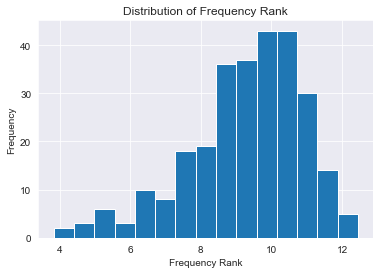

In [25]:
plt.hist(wordle_words['freq_rank_log'], bins= 15)
plt.title('Distribution of Frequency Rank')
plt.xlabel('Frequency Rank')
plt.ylabel('Frequency')
plt.show()

Let us proceed with gathering our population mean and standard deviation as well as our sample mean to compute our test statistic, now using the freq_rank_log column

**Population Mean and Standard Deviation for freq_rank_log**

In [26]:
wordle_words['freq_rank_log'].describe().T

count    277.000000
mean       9.262212
std        1.640096
min        3.828641
25%        8.439448
50%        9.528067
75%       10.438518
max       12.454260
Name: freq_rank_log, dtype: float64

**Sample Mean for freq_rank_log, our sample is all 52 words after NYT purchase**

In [27]:
wordle_words['freq_rank_log'][wordle_words['Before_nyt'] == False].describe().T

count    52.000000
mean      8.973068
std       1.840660
min       3.828641
25%       8.096328
50%       9.470435
75%      10.323972
max      11.893141
Name: freq_rank_log, dtype: float64

**Preforming a z-test:** 

The mean (mu) log frequency rank for the population is 9.262212
the standard deviation (sigma) of log frequency ranks for the population is 1.640096
the sample mean is 8.973068
the sample size is 52. 

𝐻0 :  𝜇  = 9.262212

𝐻𝑎 :  𝜇   ≠  9.262212

 𝛼 = 0.05

In [28]:
import scipy.stats as stats

sample_mean = 8.973068
n= 52
mu = 9.262212
sigma = 1.640096

In [29]:
test_stat =  (sample_mean - mu)/(sigma/np.sqrt(n)) 
test_stat

-1.2712957265827862

In [30]:
p_value1 = stats.norm.cdf(test_stat)

p_value_ztest = p_value1*2

print(p_value_ztest)

0.20362346206805215


## Conclusion 

p value = 0.2036 Level of significance: 0.05

We have no evidence to reject the null hypothesis since p-value is greater than the Level of Significance. So we can not say that Wordle has gotten easier or harder (since this was a two-sided test).

I'm going to take this table to Tableau to take a closer look and beautify the figure.

In [31]:
wordle_words.to_csv(r'wordle_csv_merge.csv')